Цель работы - разработка параллельной реализации задачи N-тел с использованием OpenMP и оценка производительности алгоритма на CPU.

Задача N-тел реализуется по закону всемирного тяготения с использованием метода Эйлера первого порядка. Вычисляются траектории N материальных точек за время t. Каждое тело представлено координатами и скоростями в двумерной плоскости, а взаимодействие между телами рассчитывается по закону всемирного тяготения, что требует суммирования вкладов сил от всех остальных тел. Основной вычислительный блок - двойной цикл по всем парам частиц, который параллелится с помощью OpenMP. Для избежания гонок данных при записи сил в массивы используется либо атомарные операции, либо локальные массивы потоков с последующим суммированием. Обновление скоростей и координат также выполняется параллельно, что должно обеспечивать ускорение при многопоточной обработке.

Программа рассчитана на CPU с поддержкой OpenMP, замеры проводились в Google Colab на виртуальной машине: CPU 2–4 ядра, Linux Ubuntu 20.04 LTS. Для визуализации и анализа результатов замеров использовался Colab.

In [1]:
%%writefile nbody_openmp.c

Writing nbody_openmp.c


In [2]:
import pandas as pd

In [3]:
!gcc --version

gcc (Ubuntu 11.4.0-1ubuntu1~22.04.2) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



Первый инпут: два тела на линии x, движутся навстречу друг другу по оси y, ожидается вращательное движение вокруг центра масс.

In [6]:
%%bash
cat > input1.txt << EOF
2
0.0 0.0 0.0  0.0  0.1  0.0
1.0 0.0 0.0  0.0 -0.1  0.0
EOF

In [24]:
!gcc -O2 -fopenmp nbody_openmp.c -o nbody_openmp -lm


nbody_openmp.c: In function ‘main’:
nbody_openmp.c:26:5: warning: ignoring return value of ‘fscanf’ declared with attribute ‘warn_unused_result’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-result-Wunused-result]8;;]
   26 |     fscanf(fin, "%d", &n);
      |     ^~~~~~~~~~~~~~~~~~~~~
nbody_openmp.c:35:9: warning: ignoring return value of ‘fscanf’ declared with attribute ‘warn_unused_result’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-result-Wunused-result]8;;]
   35 |         fscanf(fin, "%lf %lf %lf %lf %lf %lf",
      |         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   36 |                &x[i], &y[i], &z, &vx[i], &vy[i], &vz);
      |                ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [25]:
!./nbody_openmp input1.txt 10.0 > result1.csv

Threads: 2, Time: 0.004185 seconds


In [26]:
df = pd.read_csv('result1.csv')
print(df)

          t   x1     y1   x2     y2
0      0.00  0.0  0.000  1.0  0.000
1      0.01  0.0  0.001  1.0 -0.001
2      0.02  0.0  0.002  1.0 -0.002
3      0.03  0.0  0.003  1.0 -0.003
4      0.04  0.0  0.004  1.0 -0.004
...     ...  ...    ...  ...    ...
996    9.96  0.0  0.996  1.0 -0.996
997    9.97  0.0  0.997  1.0 -0.997
998    9.98  0.0  0.998  1.0 -0.998
999    9.99  0.0  0.999  1.0 -0.999
1000  10.00  0.0  1.000  1.0 -1.000

[1001 rows x 5 columns]


Второй инпут: три тела, расположенные в форме треугольника, с начальными скоростями, ожидается более сложная траектория.

In [27]:
%%bash
cat > input2.txt << EOF
3
-1.0 0.0 0.0  0.0 0.3 0.0
1.0  0.0 0.0  0.0 -0.3 0.0
0.0  0.5 0.0 -0.3 0.0 0.0
EOF

In [28]:
!./nbody_openmp input2.txt 10.0 > result2.csv

Threads: 2, Time: 0.004907 seconds


In [29]:
df = pd.read_csv('result2.csv')
print(df)

          t   x1     y1   x2     y2     x3   y3
0      0.00 -1.0  0.000  1.0  0.000  0.000  0.5
1      0.01 -1.0  0.003  1.0 -0.003 -0.003  0.5
2      0.02 -1.0  0.006  1.0 -0.006 -0.006  0.5
3      0.03 -1.0  0.009  1.0 -0.009 -0.009  0.5
4      0.04 -1.0  0.012  1.0 -0.012 -0.012  0.5
...     ...  ...    ...  ...    ...    ...  ...
996    9.96 -1.0  2.988  1.0 -2.988 -2.988  0.5
997    9.97 -1.0  2.991  1.0 -2.991 -2.991  0.5
998    9.98 -1.0  2.994  1.0 -2.994 -2.994  0.5
999    9.99 -1.0  2.997  1.0 -2.997 -2.997  0.5
1000  10.00 -1.0  3.000  1.0 -3.000 -3.000  0.5

[1001 rows x 7 columns]


In [13]:
%%writefile nbody_openmp_metrics.c

Writing nbody_openmp_metrics.c


In [19]:
!gcc -O2 -fopenmp nbody_openmp_metrics.c -o nbody_bench -lm

nbody_openmp_metrics.c: In function ‘main’:
nbody_openmp_metrics.c:26:5: warning: ignoring return value of ‘fscanf’ declared with attribute ‘warn_unused_result’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-result-Wunused-result]8;;]
   26 |     fscanf(fin, "%d", &n);
      |     ^~~~~~~~~~~~~~~~~~~~~
nbody_openmp_metrics.c:35:9: warning: ignoring return value of ‘fscanf’ declared with attribute ‘warn_unused_result’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-result-Wunused-result]8;;]
   35 |         fscanf(fin, "%lf %lf %lf %lf %lf %lf",
      |         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   36 |                &x[i], &y[i], &z, &vx[i], &vy[i], &vz);
      |                ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [23]:
!OMP_NUM_THREADS=1 ./nbody_bench input2.txt 1000.0
!OMP_NUM_THREADS=2 ./nbody_bench input2.txt 1000.0
!OMP_NUM_THREADS=4 ./nbody_bench input2.txt 1000.0
!OMP_NUM_THREADS=8 ./nbody_bench input2.txt 1000.0
!OMP_NUM_THREADS=16 ./nbody_bench input2.txt 1000.0

Threads: 1, Time: 0.102563 seconds
Threads: 2, Time: 0.140553 seconds
Threads: 4, Time: 5.371888 seconds
Threads: 8, Time: 17.624505 seconds
Threads: 16, Time: 42.130163 seconds


In [21]:
import pandas as pd
#для 5.0
threads = [1, 2, 4, 8, 16]
times = [0.000729, 0.001431, 0.023586, 0.092112, 0.169722]

T1 = times[0]
S = [T1 / t for t in times]
E = [s / p for s, p in zip(S, threads)]

df = pd.DataFrame({
    "Threads": threads,
    "Time (s)": times,
    "Speedup": S,
    "Efficiency": E
})

df


,Threads,Time (s),Speedup,Efficiency
0,1,0.000729,1.000000,1.000000
1,2,0.001431,0.509434,0.254717
2,4,0.023586,0.030908,0.007727
3,8,0.092112,0.007914,0.000989
4,16,0.169722,0.004295,0.000268


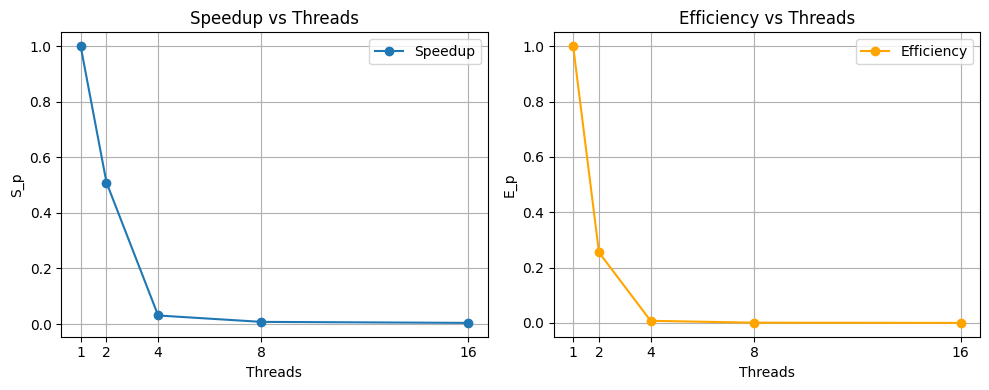

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(threads, S, 'o-', label='Speedup')
plt.xlabel('Threads')
plt.ylabel('S_p')
plt.title('Speedup vs Threads')
plt.grid(True)
plt.xticks(threads)
plt.legend()

plt.subplot(1,2,2)
plt.plot(threads, E, 'o-', color='orange', label='Efficiency')
plt.xlabel('Threads')
plt.ylabel('E_p')
plt.title('Efficiency vs Threads')
plt.grid(True)
plt.xticks(threads)
plt.legend()

plt.tight_layout()
plt.show()


Причинами такого поведения могут быть ограниченное число физических ядер в среде Colab,накладные расходы на управление потоками и синхронизацию и суммирование локальных массивов для вычисления сил после параллельного цикла(